# Import

In [13]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Import Data

In [14]:
algorithm = "GRN"
# path = f"C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\Test\\{algorithm}\\Morphologies"

# df_exp = pd.DataFrame([])
# for file in os.listdir(path):
#     if file.endswith(".csv"):
#         df_exp = pd.concat([df_exp, pd.read_csv(path + "\\" + file)])
df_exp = pd.read_csv("C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\morphological_measures_experiment_fa00c389-8ede-4571-be09-80e03a1986b5.csv")

# Only non-offspring
df_exp = df_exp.loc[df_exp.loc[:, "generation_index"] % 2 == 0, :]
df_exp["generation_index"] = df_exp.loc[:, "generation_index"].values / 2

# Assert that 20 reps are present
assert len(df_exp.loc[:, "experiment_id"].unique()) == 20

# Assert that all experiments have 51 generations
for exp_id in df_exp.loc[:, "experiment_id"].unique():
    assert len(df_exp.loc[df_exp["experiment_id"] == exp_id, "generation_index"].unique()) == 51

# Assert that all experiments have 100 individuals
assert df_exp.groupby(["experiment_id", "generation_index"]).size().unique() == 100

# Plot data over time

In [15]:
path4plots = f"C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\Test\\{algorithm}\\Morphologies\\plots\\line"
if not os.path.exists(path4plots):
    os.makedirs(path4plots)

In [16]:
# Group and apply
cols4group = [col for col in df_exp.columns if col not in ["id_string"]]
mean_exp = df_exp.loc[:, cols4group].groupby(["generation_index"]).mean()
mean_std_exp = df_exp.loc[:, cols4group].groupby(["generation_index"]).std()
max_exp = df_exp.loc[:, cols4group].groupby(["generation_index"]).max()
max_std_exp = df_exp.loc[:, cols4group].groupby(["generation_index"]).std()

cols2plot = [col for col in df_exp.columns if col not in ["id_string", "experiment_id", "generation_index", "individual_index"]]
for col in cols2plot:
    # ---- Mean
    plt.plot(mean_exp.index, mean_exp.loc[:, col], label=col)
    # Std
    plt.fill_between(mean_exp.index, mean_exp.loc[:, col] - mean_std_exp.loc[:, col], mean_exp.loc[:, col] + mean_std_exp.loc[:, col], alpha=0.2)

    # ---- Max
    plt.plot(max_exp.index, max_exp.loc[:, col], label=col + " max")
    # Std
    plt.fill_between(max_exp.index, max_exp.loc[:, col] - max_std_exp.loc[:, col], max_exp.loc[:, col] + max_std_exp.loc[:, col], alpha=0.2)

    # Style
    plt.xlabel("Generation", fontsize = 16, fontweight = 'bold')
    plt.ylabel(col, fontsize = 16, fontweight = 'bold')
    plt.title("Mean " + col + " over generations", fontsize = 16, fontweight = 'bold')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(path4plots + f"\\{col}.png")
    plt.close()


# Violin Plots

ValueError: X must have 2 or fewer dimensions

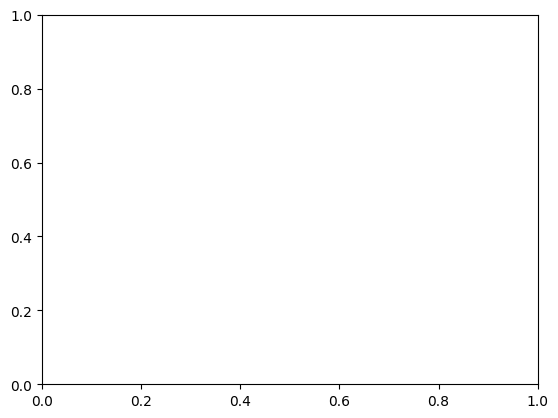

In [20]:
runs = ["init", "random search"] #, "optimization"

for run in runs:
    # Create directory for violin plots
    path4plots = f"C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\Test\\{algorithm}\\Morphologies\\plots\\violin\\{run}"
    if not os.path.exists(path4plots):
        os.makedirs(path4plots)

    for col in cols2plot:
        # Get data for violin plot
        data4violin = []
        #for exp in df_exp["experiment_id"].unique():
            #sub_df = df_exp.loc[df_exp["experiment_id"] == exp, [col, "generation_index"]]
        sub_df = df_exp.loc[:, [col, "generation_index"]]
        if run == "init":
            sub_df = sub_df.loc[sub_df["generation_index"] == 0, col]
        elif run == "random search":
            sub_df = sub_df.loc[np.logical_and(sub_df["generation_index"] > 0, sub_df["generation_index"] <= 50), col]
        elif run == "optimization":
            sub_df = sub_df.loc[sub_df["generation_index"] > 50, col]
        data4violin.append(sub_df)

        # Group data
        # Plot
        plt.violinplot(data4violin)
        plt.xlabel("Experiment", fontsize = 12, fontweight = 'bold')
        plt.ylabel(col.title(), fontsize = 12, fontweight = 'bold')
        plt.title(col.title(), fontsize = 14, fontweight = 'bold')
        plt.tight_layout()
        plt.grid()
        print(path4plots + f"\\{col}.png")
        plt.savefig(path4plots + f"\\{col}.png")
        plt.close()

# Niches

In [ ]:
# Set number of bins
ncubes = {"coverage": 1000, "size": 1000, "proportion2d": 1000, "single_neighbour_brick_ratio": 1000,
          "double_neighbour_brick_and_active_hinge_ratio": 1000, "joints": 1000, "branching": 1000} #"symmetry": 1000, 
# Create bins
bins = {}
for col in ncubes.keys():
    bins[col] = np.linspace(df_exp[col].min(), df_exp[col].max(), ncubes[col])

# Get cube indices
cubes = {}
for col in ncubes.keys():
    cubes[col] = np.digitize(df_exp[col], bins[col])

# New Dataframe
df_bins = pd.DataFrame(cubes)
# df_bins["generation_index"] = df_exp["generation_index"].values
# df_bins["experiment_id"] = df_exp["experiment_id"].values

# Get generation index
gens = df_exp["generation_index"].values

# Get bin counts per generation and overall
gencubes = {}
overallcubes = {}
for index, row in df_bins.iterrows():
    # Set generation?
    if gens[index] not in gencubes.keys():
        gencubes[gens[index]] = {}
    if gens[index] not in overallcubes.keys():
        overallcubes[gens[index]] = 0
    # Set cube?
    if "-".join([str(row[col]) for col in ncubes.keys()]) not in gencubes[gens[index]].keys():
        gencubes[gens[index]]["-".join([str(row[col]) for col in ncubes.keys()])] = 1
    else:
        gencubes[gens[index]]["-".join([str(row[col]) for col in ncubes.keys()])] += 1

    # Overall
    if "-".join([str(row[col]) for col in ncubes.keys()]) not in overallcubes.keys():
        overallcubes["-".join([str(row[col]) for col in ncubes.keys()])]= 1
    else:
        overallcubes["-".join([str(row[col]) for col in ncubes.keys()])]+= 1

# New phenotypes over time
explored = []
accumulated = []
prev_acc = 0

for gen in range(0, int(max(list(gencubes.keys()))) + 1):
    acc = 0
    for cube in gencubes[gen].keys():
        if cube not in explored:
            explored.append(cube)
            acc += 1
    # Accumulated score        
    accumulated.append(acc + prev_acc)
    prev_acc = accumulated[-1]


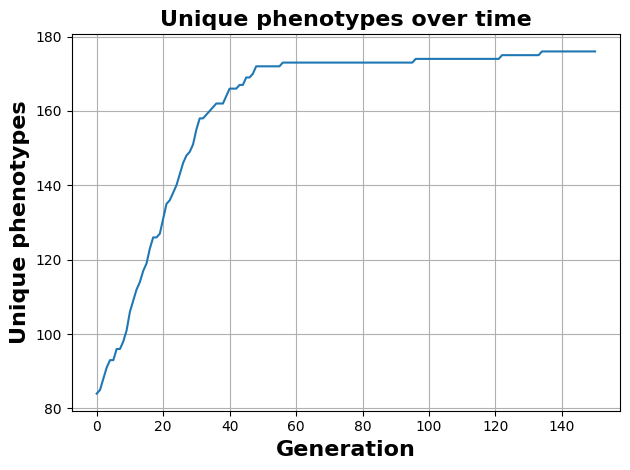

In [ ]:
plt.plot(accumulated, "-")
plt.xlabel("Generation", fontsize = 16, fontweight = 'bold')
plt.ylabel("Unique phenotypes", fontsize = 16, fontweight = 'bold')
plt.title("Unique phenotypes over time", fontsize = 16, fontweight = 'bold')
plt.grid()
plt.tight_layout()
plt.show()

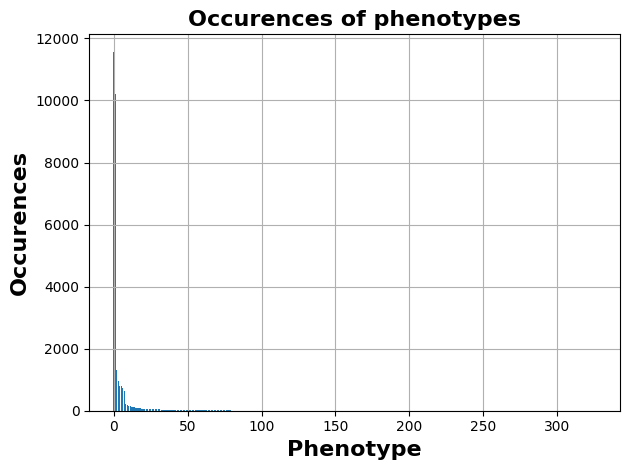

In [ ]:
cubevalues = list(overallcubes.values())
cubevalues.sort(reverse=True)
plt.bar(range(0, len(cubevalues)), cubevalues)
plt.xlabel("Phenotype", fontsize = 16, fontweight = 'bold')
plt.ylabel("Occurences", fontsize = 16, fontweight = 'bold')
plt.title("Occurences of phenotypes", fontsize = 16, fontweight = 'bold')
plt.grid()
plt.tight_layout()
plt.show()
